# Questions Classifier

Kelompok B - IF5172 Datawarehouse & Data Mining
- Anindya Prameswari			13518034
- William Fu 				13518055
- Hollyana Puteri Haryono		18218013
- Adriel Gustino P. Situmorang		18218047
- Arief Purnama Muharram		23521013

## Set up

Shortcut folder [ini](https://drive.google.com/drive/u/2/folders/1dJ2DJ3Z7jbS8Xz7V8E2aoksmrZH5PrhW) ke direktori My Drive agar dapat diakses lewat Google Colab

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")
%cd "gdrive/MyDrive/Tubes DWDM"

Mounted at /content/gdrive
/content/gdrive/.shortcut-targets-by-id/1dJ2DJ3Z7jbS8Xz7V8E2aoksmrZH5PrhW/Tubes DWDM


In [ ]:
!pip install --upgrade nltk
!pip install --upgrade gensim
!pip install Sastrawi

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.5 MB 29.7 MB/s 
     |████████████████████████████████| 749 kB 57.9 MB/s 
  Attempting uninstall: regex
    Found existing installation: regex 2019.12.20
    Uninstalling regex-2019.12.20:
      Successfully uninstalled regex-2019.12.20
  Attempting uninstall: nltk
    Found existing installation: nltk 3.2.5
    Uninstalling nltk-3.2.5:
      Successfully uninstalled nltk-3.2.5
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 24.1 MB 1.2 MB/s 
  Attempting uninstall: gensim
    Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 209 kB 14.3 MB/s 


In [ ]:
# import necessary package
import numpy as np # linear algebra
np.random.seed(0)
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import re
import nltk
nltk.download('stopwords')
nltk.download('punkt')
import warnings
warnings.filterwarnings("ignore")

from nltk.corpus import stopwords
from wordcloud import WordCloud


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


## Loading Dataset, EDA, Preliminary Processing

In [ ]:
df = pd.read_csv('Graves Disease Questions Dataset_v2.csv')
df['label'] = df['label'].map(lambda x: int(x/100))
print(len(df))
df.head()

607


,label,question
0,5,Bagaimana cara mengobati penyakit Graves?
1,5,Apa obat untuk penyakit Graves?
2,5,Obat apa yang dapat menyembuhkan penyakit Graves?
3,3,Apa gejala terkena penyakit Graves?
4,3,Bagaimana tanda-tanda terkena penyakit Graves?


In [ ]:
print(df['label'].min())
print(df['label'].max())

1
6


In [ ]:
label_string = [
  "definisi", "risiko", "gejala", "diagnosis", "pengobatan", "komplikasi"
]

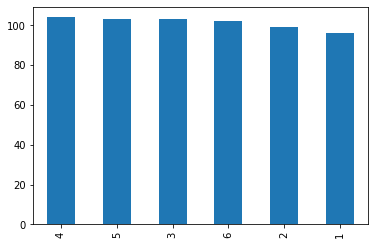

In [ ]:
# Summary
df['label'].value_counts().plot(kind='bar')

In [ ]:
df['label'].value_counts()

4    104
5    103
3    103
6    102
2     99
1     96
Name: label, dtype: int64

Max: 70 | Min: 2


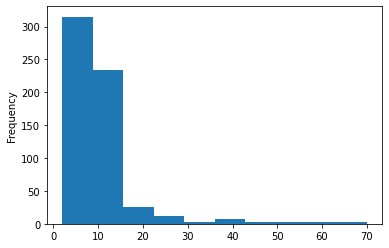

In [ ]:
# Check length per question
df['question_length'] = df['question'].str.split().str.len()
print(f"Max: {df['question_length'].max()} | Min: {df['question_length'].min()}")
df['question_length'].plot.hist()

In [ ]:
# Check which questions are very long
df.loc[df['question_length'] > 15].head()

,label,question,question_length
118,5,"Dok, saya mau nanya saya sakit penyakit Graves...",19
124,3,"Dok, saya mau nanya. Waktu itu saya ada keluha...",26
125,2,"Dok, ibu saya katanya pernah dibilang sakit Gr...",16
128,4,"Dok, katanya kalau periksa penyakit Graves itu...",16
132,4,Apakah orang yang diduga sakit Graves perlu di...,16


Sepertinya ada data yang diambil dari forum. Karena tipe pertanyaan ini berbeda dengan kebanyakan pertanyaan lainnya (pertanyaan singkat), pertanyaan forum akan dihilangkan.

In [ ]:
df_blacklisted = df[(df['question'].str.lower().str.contains("dok | dokter")) & (df['question_length'] > 15)]
print(len(df_blacklisted))
df_blacklisted.head()

26


,label,question,question_length
124,3,"Dok, saya mau nanya. Waktu itu saya ada keluha...",26
154,3,"Selamat pagi, dokter. Saya punya keluhan. Bera...",18
186,6,Dokter saya mau nanya. Mata saya melotot akhir...,28
194,6,"Hai, dokter. Saya mau nanya nih, dok. Kalau pe...",27
200,6,"Dok, nama saya Ani. Saya mau bertanya, dok. Sa...",43


In [ ]:
# We will remove all of those above
df = df[~((df['question'].str.lower().str.contains("dok | dokter")) & (df['question_length'] > 15))]
df

,label,question,question_length
0,5,Bagaimana cara mengobati penyakit Graves?,5
1,5,Apa obat untuk penyakit Graves?,5
2,5,Obat apa yang dapat menyembuhkan penyakit Graves?,7
3,3,Apa gejala terkena penyakit Graves?,5
4,3,Bagaimana tanda-tanda terkena penyakit Graves?,5
...,...,...,...
602,2,Mungkinkah penyakit Graves terjadi di usia ana...,7
603,2,Mungkinkah penyakit Graves terjadi di lansia?,6
604,2,Apakah benar merokok memicu timbulnya faktor r...,9
605,2,Kondisi hamil dan stres bisa memicu timbulnya ...,11


Max: 43 | Min: 2


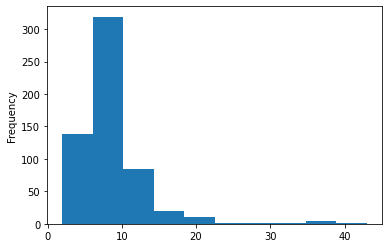

In [ ]:
# Check length per question
df['question_length'] = df['question'].str.split().str.len()
print(f"Max: {df['question_length'].max()} | Min: {df['question_length'].min()}")
df['question_length'].plot.hist()

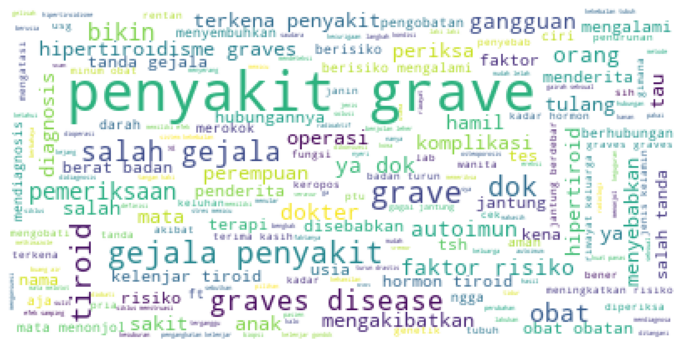

In [ ]:
text = df['question'].str.cat(sep=" ")
text = re.sub("[^a-zA-Z -]+", "", text)
text = text.lower()
stops = stopwords.words("indonesian")

wordcloud = WordCloud(background_color="white", stopwords=stops).generate(text)
plt.figure(figsize=(12, 16))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

1 definisi


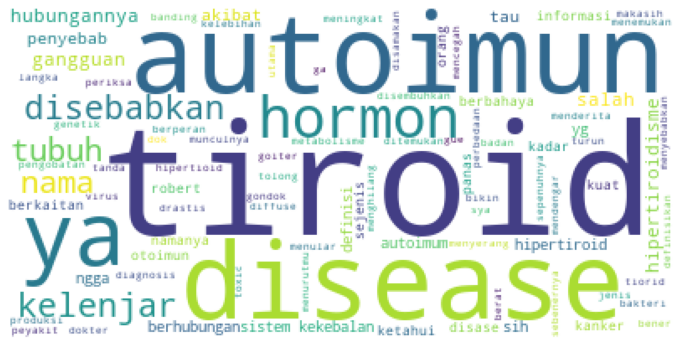

2 risiko


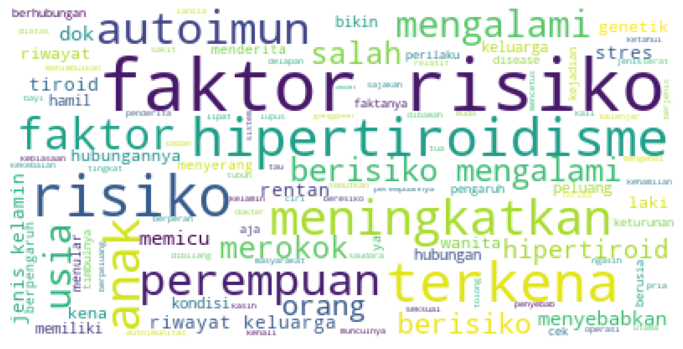

3 gejala


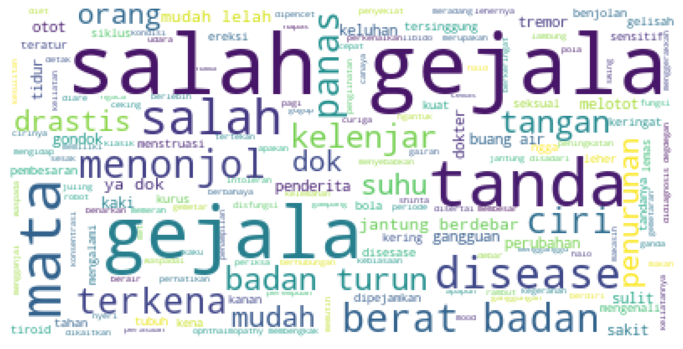

4 diagnosis


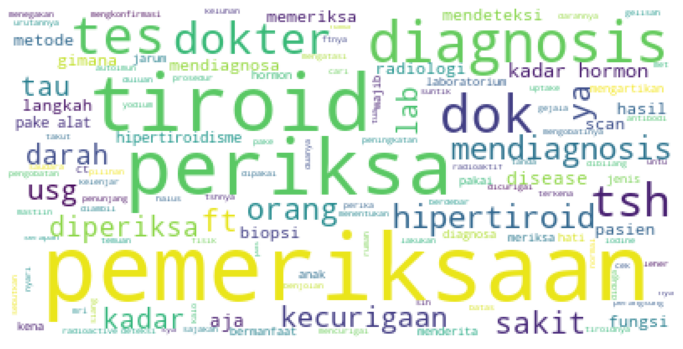

5 pengobatan


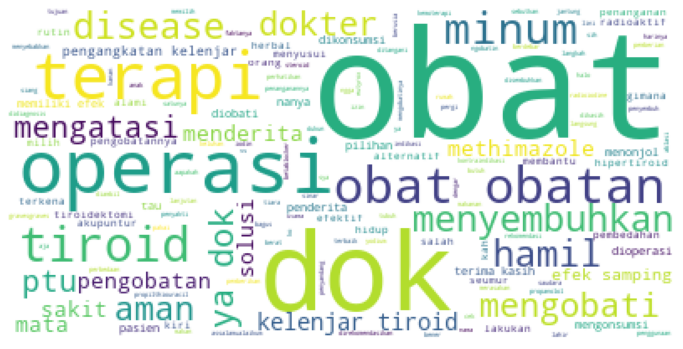

6 komplikasi


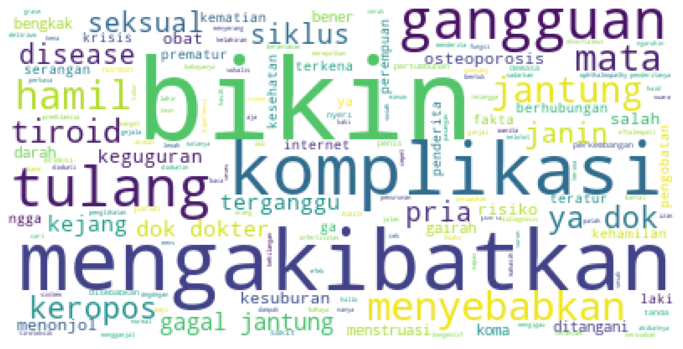

In [ ]:
# text_0 = df.loc[df['label'] == 0]['question']
text_1 = df.loc[df['label'] == 1]['question']
text_2 = df.loc[df['label'] == 2]['question']
text_3 = df.loc[df['label'] == 3]['question']
text_4 = df.loc[df['label'] == 4]['question']
text_5 = df.loc[df['label'] == 5]['question']
text_6 = df.loc[df['label'] == 6]['question']
wordcloud_texts = [text_1, text_2, text_3, text_4, text_5, text_6]

stops = stopwords.words("indonesian") 
stops = stops + ["penyakit", "graves"]

def createWordCloud(text):
  text = text.str.cat(sep=" ")
  text = re.sub("[^a-zA-Z -]+", "", text)
  text = text.lower()
  wordcloud = WordCloud(background_color="white", stopwords=stops).generate(text)
  return wordcloud

for i, text in enumerate(wordcloud_texts):
  print(f"{i+1} {label_string[i]}")
  fig = plt.figure(figsize=(12, 16))
  wordcloud = createWordCloud(text)
  plt.imshow(wordcloud)
  plt.axis("off")
  plt.show()

## Data Preprocessing

In [ ]:
# read the dictionary of slang-formal words
df_formal_words = pd.read_csv('colloquial-indonesian-lexicon.csv')
slangs_words = df_formal_words[['slang','formal']] 
slangs_words[:3]

,slang,formal
0,woww,wow
1,aminn,amin
2,met,selamat


In [ ]:
df['question_clean'] = df['question'].apply(lambda x: re.sub("'", '', x.lower()))
df['question_clean'].head(3)

0            bagaimana cara mengobati penyakit graves?
1                      apa obat untuk penyakit graves?
2    obat apa yang dapat menyembuhkan penyakit graves?
Name: question_clean, dtype: object

In [ ]:
# DATA CLEANING
# Tokenize
df['question_clean'] = df['question_clean'].apply(nltk.word_tokenize)
print('Tokenization complete.')

df[['question_clean']].head()

Tokenization complete.


,question_clean
0,"[bagaimana, cara, mengobati, penyakit, graves, ?]"
1,"[apa, obat, untuk, penyakit, graves, ?]"
2,"[obat, apa, yang, dapat, menyembuhkan, penyaki..."
3,"[apa, gejala, terkena, penyakit, graves, ?]"
4,"[bagaimana, tanda-tanda, terkena, penyakit, gr..."


In [ ]:
# Remove stop words
stop_words=set(nltk.corpus.stopwords.words("indonesian"))
stop_words = stop_words.union({'penyakit', 'grave', 'graves'})

df['question_clean'] = df['question_clean'].apply(lambda x: [item for item in x if item not in stop_words])
print('Stop words removed.')

df[['question_clean']].head()

Stop words removed.


,question_clean
0,"[mengobati, ?]"
1,"[obat, ?]"
2,"[obat, menyembuhkan, ?]"
3,"[gejala, terkena, ?]"
4,"[tanda-tanda, terkena, ?]"


In [ ]:
# Remove numbers, punctuation and special characters (only keep words)
regex = '[a-z]+'
df['question_clean'] = df['question_clean'].apply(lambda x: [item for item in x if re.match(regex, item)])
print('Numbers, punctuation and special characters removed.')

df[['question_clean']].head()

Numbers, punctuation and special characters removed.


,question_clean
0,[mengobati]
1,[obat]
2,"[obat, menyembuhkan]"
3,"[gejala, terkena]"
4,"[tanda-tanda, terkena]"


In [ ]:
# import StemmerFactory class
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

df['question_clean'] = df['question_clean'].apply(lambda x: ' '.join(x))

# create stemmer
factory = StemmerFactory()
stemmer = factory.create_stemmer()

# stemming process
df['question_clean'] = df['question_clean'].apply(lambda x: stemmer.stem(x))
df.head()

,label,question,question_length,question_clean
0,5,Bagaimana cara mengobati penyakit Graves?,5,obat
1,5,Apa obat untuk penyakit Graves?,5,obat
2,5,Obat apa yang dapat menyembuhkan penyakit Graves?,7,obat sembuh
3,3,Apa gejala terkena penyakit Graves?,5,gejala kena
4,3,Bagaimana tanda-tanda terkena penyakit Graves?,5,tanda kena


In [ ]:
df['question_token'] = df['question_clean'].map(lambda x: x.split())
df.head()

,label,question,question_length,question_clean,question_token
0,5,Bagaimana cara mengobati penyakit Graves?,5,obat,[obat]
1,5,Apa obat untuk penyakit Graves?,5,obat,[obat]
2,5,Obat apa yang dapat menyembuhkan penyakit Graves?,7,obat sembuh,"[obat, sembuh]"
3,3,Apa gejala terkena penyakit Graves?,5,gejala kena,"[gejala, kena]"
4,3,Bagaimana tanda-tanda terkena penyakit Graves?,5,tanda kena,"[tanda, kena]"


In [ ]:
df_prep = df.copy()
df_prep = df_prep.drop(columns=['question', 'question_token'])
df_prep.head()

,label,question_length,question_clean
0,5,5,obat
1,5,5,obat
2,5,7,obat sembuh
3,3,5,gejala kena
4,3,5,tanda kena


In [ ]:
# Dropping data wth label 0
df = df.loc[df['label'] != 0]
print(len(df))
df.head()

581


,label,question,question_length,question_clean,question_token
0,5,Bagaimana cara mengobati penyakit Graves?,5,obat,[obat]
1,5,Apa obat untuk penyakit Graves?,5,obat,[obat]
2,5,Obat apa yang dapat menyembuhkan penyakit Graves?,7,obat sembuh,"[obat, sembuh]"
3,3,Apa gejala terkena penyakit Graves?,5,gejala kena,"[gejala, kena]"
4,3,Bagaimana tanda-tanda terkena penyakit Graves?,5,tanda kena,"[tanda, kena]"


In [ ]:
df = df[df['question_token'].map(lambda d: len(d)) > 0]
print(len(df))
df.head()

573


,label,question,question_length,question_clean,question_token
0,5,Bagaimana cara mengobati penyakit Graves?,5,obat,[obat]
1,5,Apa obat untuk penyakit Graves?,5,obat,[obat]
2,5,Obat apa yang dapat menyembuhkan penyakit Graves?,7,obat sembuh,"[obat, sembuh]"
3,3,Apa gejala terkena penyakit Graves?,5,gejala kena,"[gejala, kena]"
4,3,Bagaimana tanda-tanda terkena penyakit Graves?,5,tanda kena,"[tanda, kena]"


### Train/Test Split

In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV

df_attr = np.array(df_prep['question_clean'])
df_label = np.array(df_prep['label'])

preprocess_train, preprocess_test, y_train, y_test = train_test_split(
    df_attr, df_label, test_size=0.3,
    random_state=42, stratify=df_label
)

print(f"Train dataset: {preprocess_train.shape}")
print(f"Test dataset: {preprocess_test.shape}")

Train dataset: (406,)
Test dataset: (175,)


In [ ]:
preprocess_train[:5]

array(['bahaya', 'komplikasi', 'kondisi hamil salah cetus picu autoimun',
       'dok ya makasih', 'derita'], dtype=object)

## Deep Learning

### Data Prep

In [ ]:
# Adapted from https://github.com/python-engineer/tensorflow-course/blob/master/11_NLP.ipynb

from collections import Counter

df_prep_copy = df_prep.copy()
df_prep_copy = df_prep_copy.sample(frac=1)
# df_prep_copy['question_clean'] = df_prep_copy['question_clean'].apply(lambda x: " ".join(x))

# Count unique words
counter = Counter()
for text in df_prep_copy['question_clean'].values:
  for word in text.split():
    counter[word] += 1

print('Num of unique words')
print(len(counter))

Num of unique words
442


In [ ]:
from keras.utils import np_utils

df_attr = df_prep_copy['question_clean']
df_label = df_prep_copy['label']
dummy_y = np_utils.to_categorical(df_label)

# Split the data in 70:10:20 for train:valid:test dataset
train_size = 0.7
valid_size = 0.1

train_index = int(len(df) * train_size)
valid_index = int(len(df) * valid_size)

preprocess_train = df_attr[:train_index]
preprocess_val = df_attr[train_index : train_index+valid_index]
preprocess_test = df_attr[train_index+valid_index:]

y_train = dummy_y[:train_index]
y_val = dummy_y[train_index:train_index+valid_index]
y_test = dummy_y[train_index+valid_index:]

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer

# vectorize a text corpus by turning each text into a sequence of integers
tokenizer = Tokenizer(num_words=len(counter))
tokenizer.fit_on_texts(preprocess_train) # fit only to training

In [ ]:
word_index = tokenizer.word_index
train_sequences = tokenizer.texts_to_sequences(preprocess_train)
validation_sequences = tokenizer.texts_to_sequences(preprocess_val)
test_sequences = tokenizer.texts_to_sequences(preprocess_test)

In [ ]:
print('Train questions')
print(preprocess_train.to_numpy()[:7])
print('Train sequences')
print(train_sequences[:7])

Train questions
['periksa tiroid pake alat usg' 'akibat gagal jantung'
 'tolong informasi nama' 'tular hubung seksual' 'tangan' 'risiko kena'
 'sulit tidur gelisah salah gejala']
Train sequences
[[7, 1, 102, 103, 55], [26, 104, 28], [133, 196, 45], [105, 17, 56], [36], [3, 13], [134, 73, 106, 5, 4]]


In [ ]:
# Pad the sequences to have the same length
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Max number of words in a sequence
max_length = 20

train_padded = pad_sequences(train_sequences, maxlen=max_length, padding="post", truncating="post")
val_padded = pad_sequences(validation_sequences, maxlen=max_length, padding="post", truncating="post")
test_padded = pad_sequences(test_sequences, maxlen=max_length, padding="post", truncating="post")

train_padded.shape, val_padded.shape

((401, 20), (57, 20))

In [ ]:
train_labels = y_train
val_labels = y_val
test_labels = y_test

print(preprocess_train.to_numpy()[0])
print(train_sequences[0])
print(train_padded[0])

periksa tiroid pake alat usg
[7, 1, 102, 103, 55]
[  7   1 102 103  55   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0]


In [ ]:
reverse_word_index = dict([(idx, word) for (word, idx) in word_index.items()])

def decode(sequence):
    return " ".join([reverse_word_index.get(idx, "?") for idx in sequence])

decoded_text = decode(train_sequences[0])

print(train_sequences[0])
print(decoded_text)

[7, 1, 102, 103, 55]
periksa tiroid pake alat usg


### Plain models

In [ ]:
from tensorflow.keras import layers, models, losses, optimizers, regularizers
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model

from sklearn.metrics import classification_report
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score


In [ ]:
def plot_history(history):
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()

  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()

In [ ]:
def compile_evaluate_model(model, best_model_path):
  loss = losses.CategoricalCrossentropy(from_logits=False)
  optim = optimizers.Adam(lr=0.001)
  metrics = ["accuracy"]

  model.compile(loss=loss, optimizer=optim, metrics=metrics)

  es = EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=5)
  mc = ModelCheckpoint(best_model_path, monitor="val_accuracy", mode="max", verbose=0, save_best_only=True)

  history = model.fit(train_padded, train_labels, epochs=300, validation_data=(val_padded, val_labels), batch_size=5, verbose=0, callbacks=[es, mc])
  plot_history(history)

  best_model = load_model(best_model_path)
  predictions = best_model.predict(test_padded)
  predicted_label = np.asarray([ np.where(arr == np.amax(arr))[0][0] for arr in predictions ]) 
  actual_label = np.asarray([ np.where(arr == np.amax(arr))[0][0] for arr in test_labels ]) 

  print(classification_report(actual_label, predicted_label))

  print("Accuracy: %1.3f \tPrecision: %1.3f \tRecall: %1.3f \t\tF1: %1.3f\n" % 
    (
      accuracy_score(actual_label, predicted_label),
      precision_score(actual_label, predicted_label, average='macro'), 
      recall_score(actual_label, predicted_label, average='macro'),
      f1_score(actual_label, predicted_label, average='macro')
    )
  )

  # print(preprocess_test[:15])
  print("True:", actual_label[:15])
  print("Pred:", predicted_label[:15])

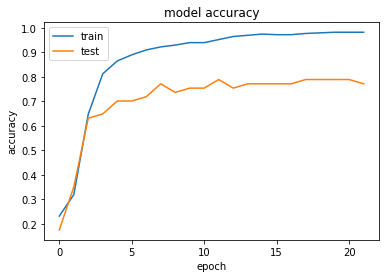

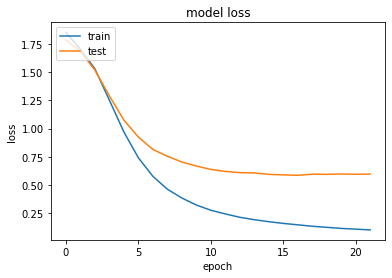

              precision    recall  f1-score   support

           1       0.71      0.85      0.77        20
           2       0.85      1.00      0.92        17
           3       0.88      0.79      0.83        19
           4       0.83      0.83      0.83        24
           5       1.00      0.95      0.97        20
           6       0.89      0.74      0.81        23

    accuracy                           0.85       123
   macro avg       0.86      0.86      0.86       123
weighted avg       0.86      0.85      0.85       123

Accuracy: 0.854 	Precision: 0.861 	Recall: 0.860 		F1: 0.857

True: [1 3 5 3 3 4 3 1 5 6 2 2 6 6 2]
Pred: [1 3 5 3 3 4 3 1 5 1 2 2 6 6 2]


In [ ]:
model = models.Sequential()
model.add(layers.Embedding(len(counter), 32, input_length=max_length))

model.add(layers.Flatten())
model.add(layers.Dense(7, activation="sigmoid"))

compile_evaluate_model(model, "Experiment Models/plain_dense1.h5")

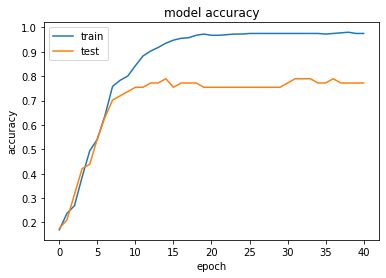

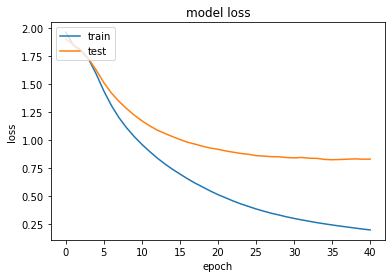

              precision    recall  f1-score   support

           1       0.68      0.65      0.67        20
           2       0.84      0.94      0.89        17
           3       0.93      0.68      0.79        19
           4       0.72      0.88      0.79        24
           5       0.85      0.85      0.85        20
           6       0.82      0.78      0.80        23

    accuracy                           0.80       123
   macro avg       0.81      0.80      0.80       123
weighted avg       0.80      0.80      0.80       123

Accuracy: 0.797 	Precision: 0.808 	Recall: 0.797 		F1: 0.798

True: [1 3 5 3 3 4 3 1 5 6 2 2 6 6 2]
Pred: [1 3 5 3 3 4 3 1 5 6 2 2 6 6 2]


In [ ]:
model = models.Sequential()
model.add(layers.Embedding(len(counter), 32, input_length=max_length))

model.add(layers.Flatten())
model.add(layers.Dense(7, activation="sigmoid"))
model.add(layers.Dense(7, activation="sigmoid"))

compile_evaluate_model(model, "Experiment Models/plain_dense2.h5")

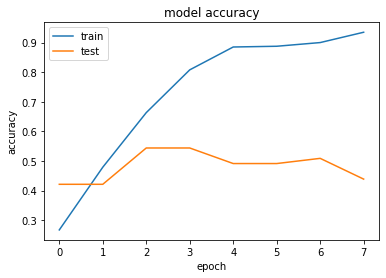

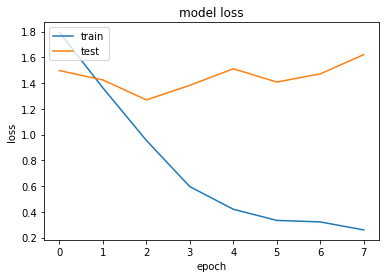

              precision    recall  f1-score   support

           1       0.57      0.60      0.59        20
           2       0.43      0.71      0.53        17
           3       0.79      0.58      0.67        19
           4       0.68      0.54      0.60        24
           5       0.68      0.75      0.71        20
           6       0.42      0.35      0.38        23

    accuracy                           0.58       123
   macro avg       0.60      0.59      0.58       123
weighted avg       0.60      0.58      0.58       123

Accuracy: 0.577 	Precision: 0.595 	Recall: 0.587 		F1: 0.581

True: [1 3 5 3 3 4 3 1 5 6 2 2 6 6 2]
Pred: [5 2 5 3 3 4 3 4 4 2 2 2 6 2 2]


In [ ]:
model = models.Sequential()
model.add(layers.Embedding(len(counter), 32, input_length=max_length))
model.add(layers.SimpleRNN(128, dropout=0.1))
model.add(layers.Dense(7, activation="sigmoid"))

compile_evaluate_model(model, "Experiment Models/plain_rnn.h5")

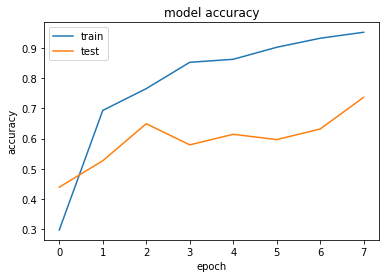

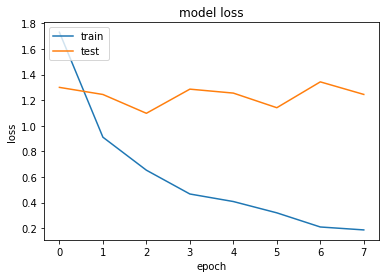

              precision    recall  f1-score   support

           1       0.64      0.80      0.71        20
           2       0.70      0.94      0.80        17
           3       0.67      0.53      0.59        19
           4       0.78      0.75      0.77        24
           5       0.67      0.70      0.68        20
           6       0.75      0.52      0.62        23

    accuracy                           0.70       123
   macro avg       0.70      0.71      0.69       123
weighted avg       0.70      0.70      0.69       123

Accuracy: 0.699 	Precision: 0.700 	Recall: 0.707 		F1: 0.694

True: [1 3 5 3 3 4 3 1 5 6 2 2 6 6 2]
Pred: [1 3 5 3 3 4 2 1 5 3 2 2 6 6 2]


In [ ]:
model = models.Sequential()
model.add(layers.Embedding(len(counter), 32, input_length=max_length))
model.add(layers.SimpleRNN(128, dropout=0.1, return_sequences=True))
model.add(layers.SimpleRNN(128, dropout=0.1))
model.add(layers.Dense(7, activation="sigmoid"))

compile_evaluate_model(model, "Experiment Models/plain_rnn2.h5")

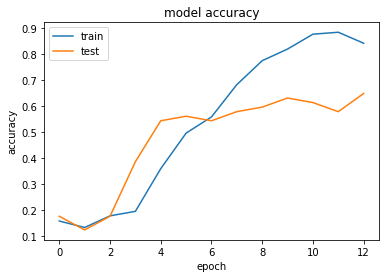

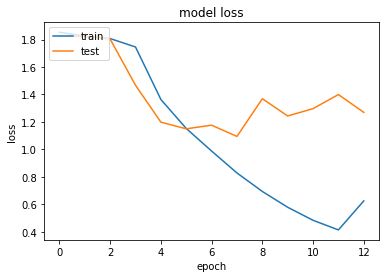

              precision    recall  f1-score   support

           1       0.48      0.50      0.49        20
           2       0.67      0.94      0.78        17
           3       0.81      0.68      0.74        19
           4       0.79      0.79      0.79        24
           5       0.85      0.55      0.67        20
           6       0.60      0.65      0.63        23

    accuracy                           0.68       123
   macro avg       0.70      0.69      0.68       123
weighted avg       0.70      0.68      0.68       123

Accuracy: 0.683 	Precision: 0.699 	Recall: 0.687 		F1: 0.682

True: [1 3 5 3 3 4 3 1 5 6 2 2 6 6 2]
Pred: [1 3 6 3 3 4 3 2 6 1 2 2 6 5 2]


In [ ]:
model = models.Sequential()
model.add(layers.Embedding(len(counter), 32, input_length=max_length))
model.add(layers.GRU(128, dropout=0.1))
model.add(layers.Dense(7, activation="sigmoid"))

compile_evaluate_model(model, "Experiment Models/plain_gru.h5")

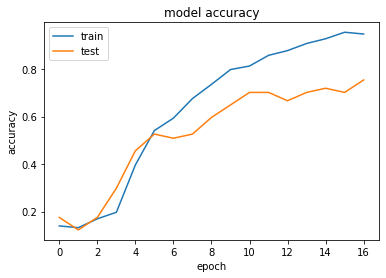

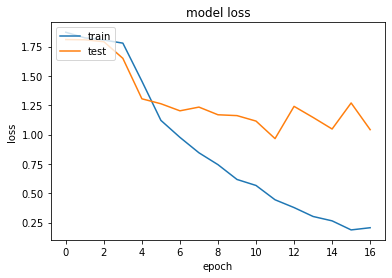

              precision    recall  f1-score   support

           1       0.52      0.70      0.60        20
           2       0.79      0.88      0.83        17
           3       0.93      0.68      0.79        19
           4       0.73      0.67      0.70        24
           5       0.72      0.90      0.80        20
           6       0.81      0.57      0.67        23

    accuracy                           0.72       123
   macro avg       0.75      0.73      0.73       123
weighted avg       0.75      0.72      0.72       123

Accuracy: 0.724 	Precision: 0.749 	Recall: 0.733 		F1: 0.730

True: [1 3 5 3 3 4 3 1 5 6 2 2 6 6 2]
Pred: [1 3 5 3 3 4 3 1 5 6 2 2 6 1 2]


In [ ]:
model = models.Sequential()
model.add(layers.Embedding(len(counter), 32, input_length=max_length))
model.add(layers.GRU(128, dropout=0.1, return_sequences=True))
model.add(layers.GRU(128, dropout=0.1))
model.add(layers.Dense(7, activation="sigmoid"))

compile_evaluate_model(model, "Experiment Models/plain_gru2.h5")

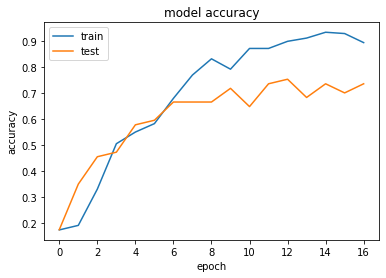

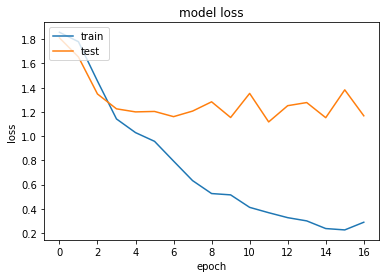

              precision    recall  f1-score   support

           1       0.54      0.70      0.61        20
           2       0.84      0.94      0.89        17
           3       0.88      0.74      0.80        19
           4       0.56      0.38      0.45        24
           5       0.60      0.60      0.60        20
           6       0.65      0.74      0.69        23

    accuracy                           0.67       123
   macro avg       0.68      0.68      0.67       123
weighted avg       0.67      0.67      0.66       123

Accuracy: 0.667 	Precision: 0.679 	Recall: 0.682 		F1: 0.674

True: [1 3 5 3 3 4 3 1 5 6 2 2 6 6 2]
Pred: [1 3 6 3 3 5 3 1 5 4 2 2 6 6 2]


In [ ]:
model = models.Sequential()
model.add(layers.Embedding(len(counter), 32, input_length=max_length))
model.add(layers.LSTM(128, dropout=0.1))
model.add(layers.Dense(7, activation="sigmoid"))

compile_evaluate_model(model, "Experiment Models/plain_lstm1.h5")

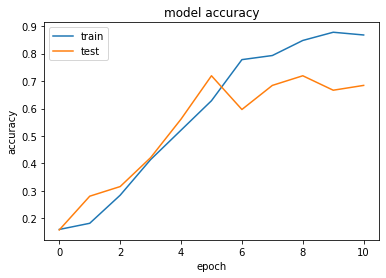

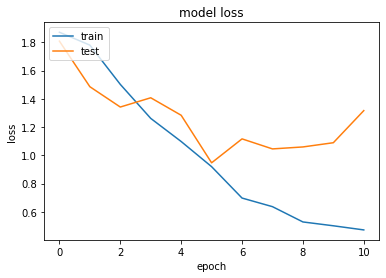

              precision    recall  f1-score   support

           1       0.35      0.55      0.43        20
           2       0.87      0.76      0.81        17
           3       0.80      0.63      0.71        19
           4       0.63      0.50      0.56        24
           5       0.57      0.65      0.60        20
           6       0.70      0.61      0.65        23

    accuracy                           0.61       123
   macro avg       0.65      0.62      0.63       123
weighted avg       0.65      0.61      0.62       123

Accuracy: 0.610 	Precision: 0.653 	Recall: 0.617 		F1: 0.627

True: [1 3 5 3 3 4 3 1 5 6 2 2 6 6 2]
Pred: [5 3 2 3 3 4 6 1 5 4 2 2 6 6 2]


In [ ]:
model = models.Sequential()
model.add(layers.Embedding(len(counter), 32, input_length=max_length))
model.add(layers.LSTM(128, dropout=0.1, return_sequences=True))
model.add(layers.LSTM(128, dropout=0.1))
model.add(layers.Dense(7, activation="sigmoid"))

compile_evaluate_model(model, "Experiment Models/plain_lstm2.h5")

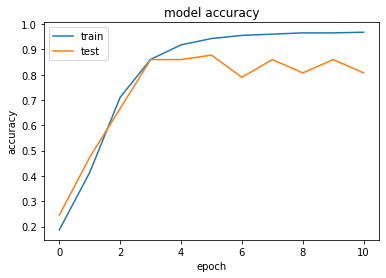

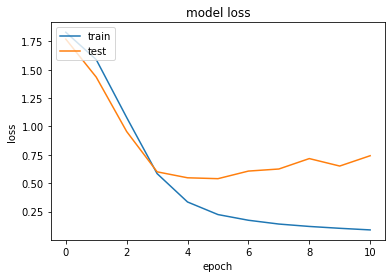

              precision    recall  f1-score   support

           1       0.68      0.85      0.76        20
           2       0.83      0.88      0.86        17
           3       0.94      0.79      0.86        19
           4       0.84      0.88      0.86        24
           5       1.00      0.75      0.86        20
           6       0.79      0.83      0.81        23

    accuracy                           0.83       123
   macro avg       0.85      0.83      0.83       123
weighted avg       0.85      0.83      0.83       123

Accuracy: 0.829 	Precision: 0.847 	Recall: 0.829 		F1: 0.832

True: [1 3 5 3 3 4 3 1 5 6 2 2 6 6 2]
Pred: [1 3 5 3 3 4 3 1 5 6 2 2 6 6 2]


In [ ]:
model = models.Sequential()
model.add(layers.Embedding(len(counter), 32, input_length=max_length))

model.add(layers.Conv1D(128, kernel_size=5))
model.add(layers.MaxPooling1D(pool_size=2))
model.add(layers.Flatten())
model.add(layers.Dense(7, activation="sigmoid"))

compile_evaluate_model(model, "Experiment Models/plain_cnn1.h5")

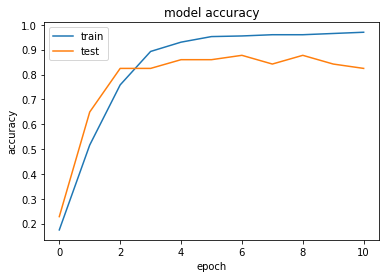

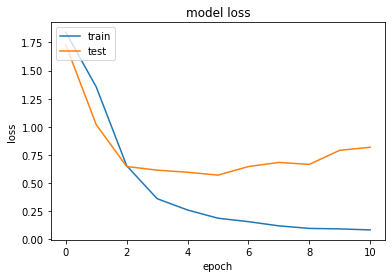

              precision    recall  f1-score   support

           1       0.76      0.80      0.78        20
           2       0.83      0.88      0.86        17
           3       0.83      0.79      0.81        19
           4       0.79      0.79      0.79        24
           5       0.94      0.80      0.86        20
           6       0.80      0.87      0.83        23

    accuracy                           0.82       123
   macro avg       0.83      0.82      0.82       123
weighted avg       0.82      0.82      0.82       123

Accuracy: 0.821 	Precision: 0.827 	Recall: 0.822 		F1: 0.823

True: [1 3 5 3 3 4 3 1 5 6 2 2 6 6 2]
Pred: [1 3 5 3 3 4 3 1 5 6 2 2 6 6 2]


In [ ]:
model = models.Sequential()
model.add(layers.Embedding(len(counter), 32, input_length=max_length))

model.add(layers.Conv1D(128, kernel_size=12))
model.add(layers.Conv1D(128, kernel_size=3))
model.add(layers.MaxPooling1D(pool_size=2))
model.add(layers.Flatten())
model.add(layers.Dense(7, activation="sigmoid"))

compile_evaluate_model(model, "Experiment Models/plain_cnn2.h5")

### Increase dropout + add kernel regularizer

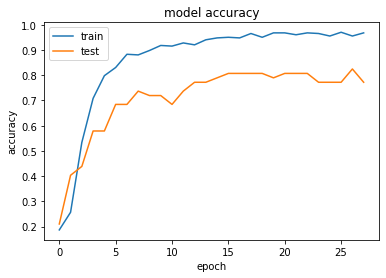

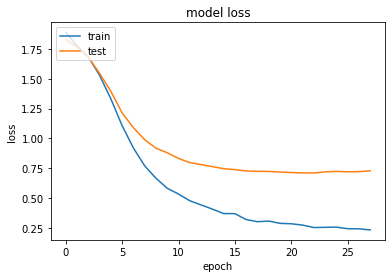

              precision    recall  f1-score   support

           1       0.70      0.80      0.74        20
           2       0.84      0.94      0.89        17
           3       0.87      0.68      0.76        19
           4       0.80      0.83      0.82        24
           5       0.94      0.85      0.89        20
           6       0.83      0.83      0.83        23

    accuracy                           0.82       123
   macro avg       0.83      0.82      0.82       123
weighted avg       0.83      0.82      0.82       123

Accuracy: 0.821 	Precision: 0.829 	Recall: 0.822 		F1: 0.822

True: [1 3 5 3 3 4 3 1 5 6 2 2 6 6 2]
Pred: [1 3 5 3 3 4 3 1 5 2 2 2 6 6 2]


In [ ]:
model = models.Sequential()
model.add(layers.Embedding(len(counter), 32, input_length=max_length))

model.add(layers.Flatten())
model.add(layers.Dropout(0.4))
model.add(layers.Dense(7, activation="sigmoid", kernel_regularizer=regularizers.l2(0.001)))

compile_evaluate_model(model, "Experiment Models/overfit_handled_dense1.h5")

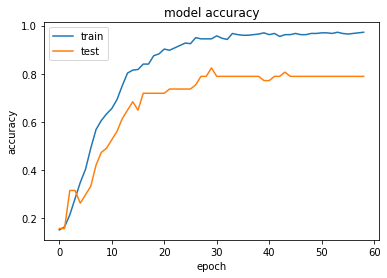

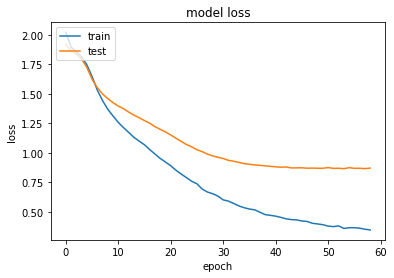

              precision    recall  f1-score   support

           1       0.71      0.75      0.73        20
           2       0.76      0.94      0.84        17
           3       1.00      0.63      0.77        19
           4       0.78      0.88      0.82        24
           5       0.90      0.90      0.90        20
           6       0.77      0.74      0.76        23

    accuracy                           0.80       123
   macro avg       0.82      0.81      0.80       123
weighted avg       0.82      0.80      0.80       123

Accuracy: 0.805 	Precision: 0.821 	Recall: 0.806 		F1: 0.805

True: [1 3 5 3 3 4 3 1 5 6 2 2 6 6 2]
Pred: [1 3 5 3 3 4 3 1 5 6 2 2 6 6 2]


In [ ]:
model = models.Sequential()
model.add(layers.Embedding(len(counter), 32, input_length=max_length))

model.add(layers.Flatten())
model.add(layers.Dropout(0.4))
model.add(layers.Dense(7, activation="sigmoid", kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.Dense(7, activation="sigmoid", kernel_regularizer=regularizers.l2(0.001)))

compile_evaluate_model(model, "Experiment Models/overfit_handled_dense2.h5")

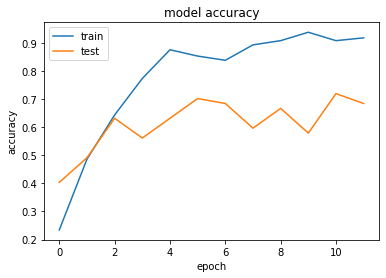

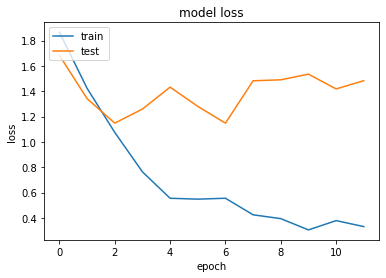

              precision    recall  f1-score   support

           1       0.79      0.75      0.77        20
           2       0.75      0.88      0.81        17
           3       0.71      0.89      0.79        19
           4       0.80      0.83      0.82        24
           5       0.94      0.85      0.89        20
           6       0.82      0.61      0.70        23

    accuracy                           0.80       123
   macro avg       0.80      0.80      0.80       123
weighted avg       0.81      0.80      0.79       123

Accuracy: 0.797 	Precision: 0.803 	Recall: 0.803 		F1: 0.797

True: [1 3 5 3 3 4 3 1 5 6 2 2 6 6 2]
Pred: [1 3 5 3 3 4 3 1 5 6 2 2 6 6 2]


In [ ]:
model = models.Sequential()
model.add(layers.Embedding(len(counter), 32, input_length=max_length))
model.add(layers.SimpleRNN(128, dropout=0.4, kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.Dense(7, activation="sigmoid", kernel_regularizer=regularizers.l2(0.001)))

compile_evaluate_model(model, "Experiment Models/overfit_handled_rnn1.h5")

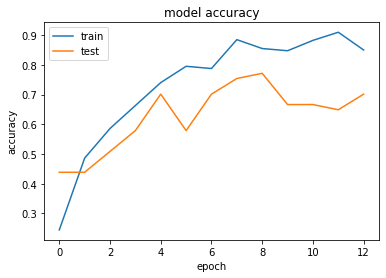

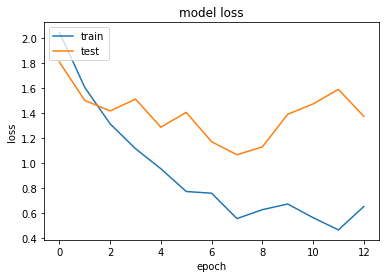

              precision    recall  f1-score   support

           1       0.54      0.75      0.63        20
           2       0.64      0.94      0.76        17
           3       0.75      0.47      0.58        19
           4       0.80      0.83      0.82        24
           5       0.88      0.70      0.78        20
           6       0.71      0.52      0.60        23

    accuracy                           0.70       123
   macro avg       0.72      0.70      0.69       123
weighted avg       0.72      0.70      0.69       123

Accuracy: 0.699 	Precision: 0.718 	Recall: 0.703 		F1: 0.694

True: [1 3 5 3 3 4 3 1 5 6 2 2 6 6 2]
Pred: [1 3 5 3 3 4 3 1 5 1 2 2 6 6 2]


In [ ]:
model = models.Sequential()
model.add(layers.Embedding(len(counter), 32, input_length=max_length))
model.add(layers.SimpleRNN(128, dropout=0.4, kernel_regularizer=regularizers.l2(0.001), return_sequences=True))
model.add(layers.SimpleRNN(128, dropout=0.4, kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.Dense(7, activation="sigmoid", kernel_regularizer=regularizers.l2(0.001)))

compile_evaluate_model(model, "Experiment Models/overfit_handled_rnn2.h5")

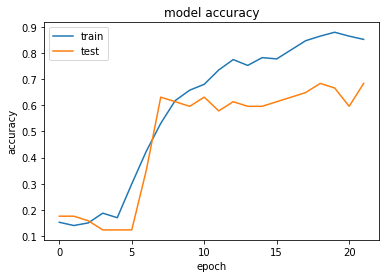

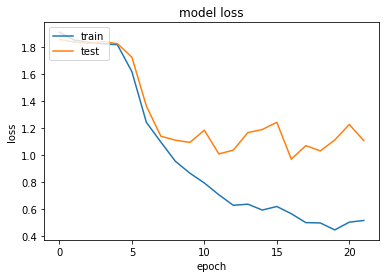

              precision    recall  f1-score   support

           1       0.64      0.80      0.71        20
           2       0.73      0.94      0.82        17
           3       0.81      0.68      0.74        19
           4       0.84      0.67      0.74        24
           5       0.75      0.75      0.75        20
           6       0.71      0.65      0.68        23

    accuracy                           0.74       123
   macro avg       0.75      0.75      0.74       123
weighted avg       0.75      0.74      0.74       123

Accuracy: 0.740 	Precision: 0.748 	Recall: 0.749 		F1: 0.742

True: [1 3 5 3 3 4 3 1 5 6 2 2 6 6 2]
Pred: [1 3 5 3 3 4 3 1 5 5 2 2 6 6 2]


In [ ]:
model = models.Sequential()
model.add(layers.Embedding(len(counter), 32, input_length=max_length))
model.add(layers.GRU(128, dropout=0.4, kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.Dense(7, activation="sigmoid", kernel_regularizer=regularizers.l2(0.001)))

compile_evaluate_model(model, "Experiment Models/overfit_handled_gru1.h5")

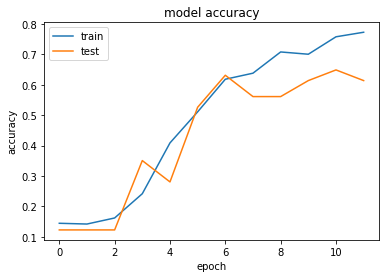

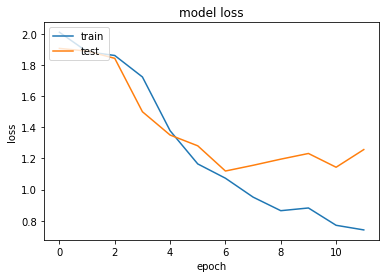

              precision    recall  f1-score   support

           1       0.50      0.60      0.55        20
           2       0.92      0.71      0.80        17
           3       0.86      0.63      0.73        19
           4       0.54      0.83      0.66        24
           5       0.67      0.50      0.57        20
           6       0.70      0.61      0.65        23

    accuracy                           0.65       123
   macro avg       0.70      0.65      0.66       123
weighted avg       0.69      0.65      0.65       123

Accuracy: 0.650 	Precision: 0.698 	Recall: 0.647 		F1: 0.659

True: [1 3 5 3 3 4 3 1 5 6 2 2 6 6 2]
Pred: [5 3 4 3 3 4 6 1 5 1 2 2 6 1 2]


In [ ]:
model = models.Sequential()
model.add(layers.Embedding(len(counter), 32, input_length=max_length))
model.add(layers.GRU(128, dropout=0.4, kernel_regularizer=regularizers.l2(0.001), return_sequences=True))
model.add(layers.GRU(128, dropout=0.4, kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.Dense(7, activation="sigmoid", kernel_regularizer=regularizers.l2(0.001)))

compile_evaluate_model(model, "Experiment Models/overfit_handled_gru2.h5")

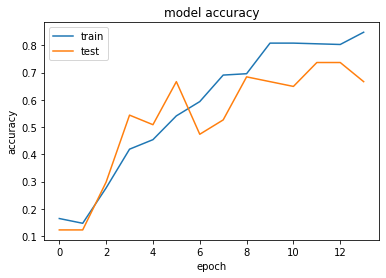

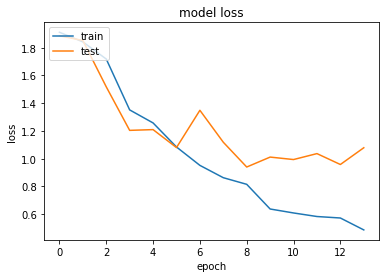

              precision    recall  f1-score   support

           1       0.60      0.60      0.60        20
           2       0.84      0.94      0.89        17
           3       0.65      0.79      0.71        19
           4       0.69      0.75      0.72        24
           5       0.81      0.65      0.72        20
           6       0.58      0.48      0.52        23

    accuracy                           0.69       123
   macro avg       0.70      0.70      0.69       123
weighted avg       0.69      0.69      0.69       123

Accuracy: 0.691 	Precision: 0.696 	Recall: 0.701 		F1: 0.695

True: [1 3 5 3 3 4 3 1 5 6 2 2 6 6 2]
Pred: [1 3 5 3 3 4 3 1 5 6 2 2 6 6 2]


In [ ]:
model = models.Sequential()
model.add(layers.Embedding(len(counter), 32, input_length=max_length))
model.add(layers.LSTM(128, dropout=0.4, kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.Dense(7, activation="sigmoid", kernel_regularizer=regularizers.l2(0.001)))

compile_evaluate_model(model, "Experiment Models/overfit_handled_lstm1.h5")

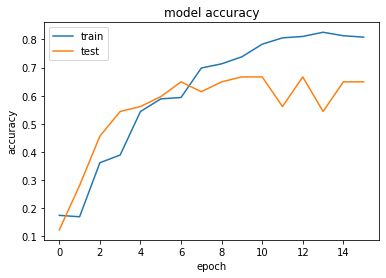

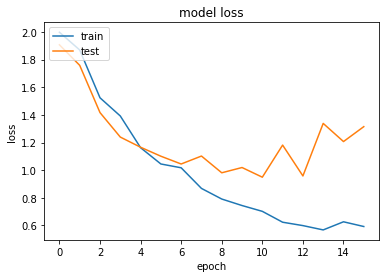

              precision    recall  f1-score   support

           1       0.40      0.20      0.27        20
           2       0.93      0.82      0.87        17
           3       0.62      0.79      0.70        19
           4       0.61      0.58      0.60        24
           5       0.46      0.80      0.58        20
           6       0.62      0.43      0.51        23

    accuracy                           0.59       123
   macro avg       0.61      0.61      0.59       123
weighted avg       0.60      0.59      0.58       123

Accuracy: 0.593 	Precision: 0.608 	Recall: 0.605 		F1: 0.588

True: [1 3 5 3 3 4 3 1 5 6 2 2 6 6 2]
Pred: [5 3 5 3 3 4 3 5 5 6 2 2 3 6 2]


In [ ]:
model = models.Sequential()
model.add(layers.Embedding(len(counter), 32, input_length=max_length))
model.add(layers.LSTM(128, dropout=0.4, return_sequences=True, kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.LSTM(128, dropout=0.4, kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.Dense(7, activation="sigmoid", kernel_regularizer=regularizers.l2(0.001)))

compile_evaluate_model(model, "Experiment Models/overfit_handled_lstm2.h5")

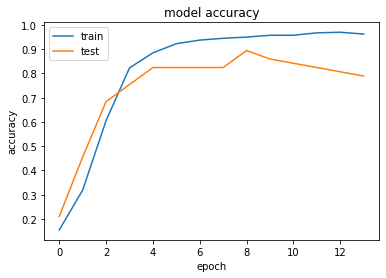

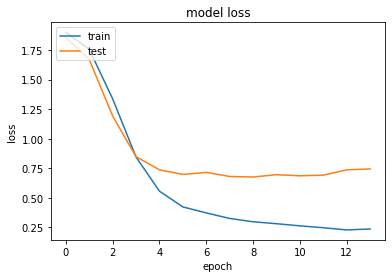

              precision    recall  f1-score   support

           1       0.74      0.85      0.79        20
           2       0.84      0.94      0.89        17
           3       1.00      0.79      0.88        19
           4       0.83      0.83      0.83        24
           5       0.95      0.95      0.95        20
           6       0.86      0.83      0.84        23

    accuracy                           0.86       123
   macro avg       0.87      0.87      0.86       123
weighted avg       0.87      0.86      0.86       123

Accuracy: 0.862 	Precision: 0.871 	Recall: 0.865 		F1: 0.865

True: [1 3 5 3 3 4 3 1 5 6 2 2 6 6 2]
Pred: [1 3 5 3 3 4 3 1 5 1 2 2 6 6 2]


In [ ]:
model = models.Sequential()
model.add(layers.Embedding(len(counter), 32, input_length=max_length))

model.add(layers.Conv1D(128, kernel_size=5, kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.Dropout(0.4))
model.add(layers.MaxPooling1D(pool_size=2))
model.add(layers.Flatten())
model.add(layers.Dense(7, activation="sigmoid", kernel_regularizer=regularizers.l2(0.001)))

compile_evaluate_model(model, "Experiment Models/overfit_handled_cnn1.h5")

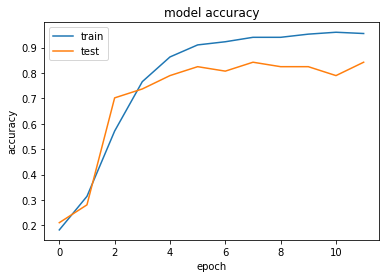

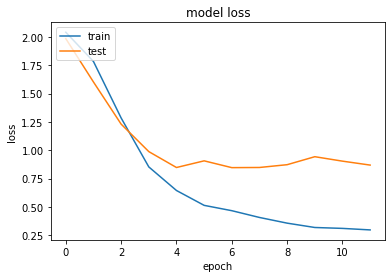

              precision    recall  f1-score   support

           1       0.71      0.85      0.77        20
           2       0.94      0.88      0.91        17
           3       0.89      0.84      0.86        19
           4       0.84      0.88      0.86        24
           5       1.00      0.90      0.95        20
           6       0.82      0.78      0.80        23

    accuracy                           0.85       123
   macro avg       0.87      0.86      0.86       123
weighted avg       0.86      0.85      0.86       123

Accuracy: 0.854 	Precision: 0.865 	Recall: 0.855 		F1: 0.859

True: [1 3 5 3 3 4 3 1 5 6 2 2 6 6 2]
Pred: [1 3 5 3 3 4 3 1 5 6 2 2 6 6 2]


In [ ]:
model = models.Sequential()
model.add(layers.Embedding(len(counter), 32, input_length=max_length))

model.add(layers.Conv1D(128, kernel_size=12, kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.Dropout(0.4))
model.add(layers.Conv1D(128, kernel_size=3, kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.Dropout(0.4))
model.add(layers.MaxPooling1D(pool_size=2))
model.add(layers.Flatten())
model.add(layers.Dense(7, activation="sigmoid", kernel_regularizer=regularizers.l2(0.001)))

compile_evaluate_model(model, "Experiment Models/overfit_handled_cnn2.h5")

## Get Prediction Samples

In [ ]:
  best_model = load_model("Experiment Models/plain_dense2.h5")
  predictions = best_model.predict(test_padded)
  predicted_label = np.asarray([ np.where(arr == np.amax(arr))[0][0] for arr in predictions ]) 
  actual_label = np.asarray([ np.where(arr == np.amax(arr))[0][0] for arr in test_labels ]) 

In [ ]:
preprocess_test

94                                              autoimun
3                                            gejala kena
503                                terapi akupuntur obat
126                           jantung debar salah gejala
305      sensitif suhu panas keringat salah tanda gejala
                             ...                        
302    temu laboratorium tingkat kadar hormon perangs...
9                                                       
384                                      darah ibu hamil
196    dok derita sakti rutin konsumsi obat rutin sal...
585                                  jenis faktor risiko
Name: question_clean, Length: 123, dtype: object

In [ ]:
test_result = pd.DataFrame(preprocess_test)
test_result['actual'] = actual_label
test_result['predicted'] = predicted_label
test_result = test_result.join(df['question'])
test_result

,question_clean,actual,predicted,question
94,autoimun,1,1,Apakah penyakit Graves merupakan penyakit auto...
3,gejala kena,3,3,Apa gejala terkena penyakit Graves?
503,terapi akupuntur obat,5,5,Apakah terapi akupuntur bisa untuk mengobati p...
126,jantung debar salah gejala,3,3,Jantung berdebar apakah salah satu gejala dari...
305,sensitif suhu panas keringat salah tanda gejala,3,3,Apakah sensitif terhadap suhu panas dan sering...
...,...,...,...,...
302,temu laboratorium tingkat kadar hormon perangs...,4,4,Apakah temuan laboratorium seperti peningkatan...
9,,1,1,NaN
384,darah ibu hamil,6,6,Darah tinggi di ibu-ibu hamil karena penyakit ...
196,dok derita sakti rutin konsumsi obat rutin sal...,5,5,"Dok, saya mau bertanya. Saya menderita penyakt..."


In [ ]:
test_result.loc[(test_result['actual'] == 1) & (test_result['predicted'] != 1)]

,question_clean,actual,predicted,question
11,hipertiroid,1,4,Apakah penyakit Graves dan hipertiroid itu sama?
239,diagnosis banding,1,4,Apakah diagnosis banding dari penyakit Graves?
202,beda hipertiroidisme,1,4,Perbedaan hipertiroidisme dengan penyakit Graves?
95,genetik,1,2,Apakah penyakit Graves merupakan penyakit gene...
144,periksa dokter,1,4,Apakah penyakit Graves perlu periksa ke dokter?
456,tau,1,4,Saya mau tau dong apa itu penyakit Graves?
457,hipertiroid ngga ya,1,4,Penyakit Graves sama penyakit hipertiroid kira...


In [ ]:
test_result.loc[(test_result['actual'] == 2) & (test_result['predicted'] != 2)]

,question_clean,actual,predicted,question
559,berat badan bikin risiko hipertiroid cek fakta,2,6,Berat badan lebih bisa bikin risiko penyakit h...


In [ ]:
test_result.loc[(test_result['actual'] == 3) & (test_result['predicted'] != 3)]

,question_clean,actual,predicted,question
206,mata melotot waspada,3,6,"Mata melotot terus waspada penyakit Graves, be..."
349,berat badan turun drastis diet tanda,3,1,Berat badan turun drastis tanpa diet merupakan...
84,kena sakit lambung,3,5,Apabila terkena Graves akan sering sakit lambung?
360,mata melotot waspada,3,6,"Mata terus melotot, waspadai penyakit Graves?"
268,mata juling,3,6,Apakah mata juling selalu berarti penyakit Gra...
448,berat badan turun drastis kurus ceking salah t...,3,1,"Benarkah berat badan turun drastis, kurus ceki..."


In [ ]:
test_result.loc[(test_result['actual'] == 4) & (test_result['predicted'] != 4)]

,question_clean,actual,predicted,question
32,kena,4,2,Bagaimana saya tahu kalau saya kena penyakit G...
291,tes serap yodium radioaktif pasien curiga,4,5,Apakah tes serapan yodium radioaktif pada pasi...
70,diagnosa,4,1,Apakah penyakit Graves dapat di diagnosa?


In [ ]:
test_result.loc[(test_result['actual'] == 5) & (test_result['predicted'] != 5)]

,question_clean,actual,predicted,question
36,langkah ambil atas,5,4,Apa langkah yang harus diambil untuk mengatasi...
149,dok bener ngga ya orang sakit minum obat umur ...,5,1,"Dok, bener ngga ya kalau orang yang sakit Grav..."
512,terapi ablasi tiroid berat,5,4,Terapi ablasi untuk masalah tiroid berat?


In [ ]:
test_result.loc[(test_result['actual'] == 6) & (test_result['predicted'] != 6)]

,question_clean,actual,predicted,question
41,hubung,6,1,Apa saja penyakit yang berhubungan dengan peny...
98,lahir prematur hamil kena,6,2,Apakah dapat terjadi kelahiran prematur bila s...
317,tangan akibat koma sadar,6,3,Apakah penyakit Graves yang tidak ditangani de...
214,dokter kena vokalis salah band diagnosis tiroi...,6,5,"Dokter, saya baru kena penyakit Graves beberap..."
87,sistem imun ganggu,6,1,Apakah sistem imun terganggu dengan adanya pen...
